<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Visualizing-weights" data-toc-modified-id="Visualizing-weights-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Visualizing weights</a></span></li><li><span><a href="#Are-all-libraries-that-are-needed-available?" data-toc-modified-id="Are-all-libraries-that-are-needed-available?-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Are all libraries that are needed available?</a></span></li><li><span><a href="#Load-a-pre-trained-CNN" data-toc-modified-id="Load-a-pre-trained-CNN-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Load a pre-trained CNN</a></span></li><li><span><a href="#Generating-a-list-of-layer-names" data-toc-modified-id="Generating-a-list-of-layer-names-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Generating a list of layer names</a></span></li><li><span><a href="#Plotting-weights-histogram-for-a-single-CONV-layer" data-toc-modified-id="Plotting-weights-histogram-for-a-single-CONV-layer-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Plotting weights histogram for a single CONV layer</a></span></li><li><span><a href="#Plotting-weights-histograms-for-all-CONV-layers" data-toc-modified-id="Plotting-weights-histograms-for-all-CONV-layers-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Plotting weights histograms for all CONV layers</a></span></li><li><span><a href="#Plotting-weights-histogram-for-a-single-FC-layer" data-toc-modified-id="Plotting-weights-histogram-for-a-single-FC-layer-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Plotting weights histogram for a single FC layer</a></span></li></ul></div>

# Visualizing weights

In this notebook we want to try to understand the weights of a trained CNN better. For this, we load in a pre-trained VGG16 CNN. Then we generate histograms of the weights per layer and finally try to visualize the weights of the first CONV layer.

# Are all libraries that are needed available?

In [1]:
import numpy as np
import tensorflow as tf
import keras
import cv2
import matplotlib
import matplotlib.pyplot as plt

print( "Your NumPy version is:      " + np.__version__ )
print( "Your TensorFlow version is: " + tf.__version__)
print( "Your Keras version is:      " + keras.__version__ )
print( "Your OpenCV version is:     " + cv2.__version__ )
print( "Your Matplotlib version is: " + matplotlib.__version__)

Using TensorFlow backend.


Your NumPy version is:      1.16.2
Your TensorFlow version is: 1.13.1
Your Keras version is:      2.1.6
Your OpenCV version is:     4.1.0
Your Matplotlib version is: 2.0.2


# Load a pre-trained CNN

In [3]:
from keras.applications import VGG16
import keras
from keras import backend as K

# clear the last Keras session
# this will clear the underlying TensorFlow graph
K.clear_session()

conv_base = VGG16(weights='imagenet', include_top=True, input_shape=(224,224,3))
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

# Generating a list of layer names

In [8]:
print("\nNumber of layers:", len(conv_base.layers))

print("\nHere are the names of all layers:")
nr_conv_layers = 0
nr_pool_layers = 0
list_layer_names = []
for layer in conv_base.layers:
    print(layer.name)
    if "conv" in layer.name:
        nr_conv_layers+=1
    if "pool" in layer.name:
        nr_pool_layers+=1
    list_layer_names.append( layer.name )

print("\nSummary:")
print("\tNr of conv layers:", nr_conv_layers)
print("\tNr of pool layers:", nr_pool_layers)
print("\nLayer names:", list_layer_names)


Number of layers: 23

Here are the names of all layers:
input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool
flatten
fc1
fc2
predictions

Summary:
	Nr of conv layers: 13
	Nr of pool layers: 5

Layer names: ['input_1', 'block1_conv1', 'block1_conv2', 'block1_pool', 'block2_conv1', 'block2_conv2', 'block2_pool', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'block3_pool', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block4_pool', 'block5_conv1', 'block5_conv2', 'block5_conv3', 'block5_pool', 'flatten', 'fc1', 'fc2', 'predictions']


# Plotting weights histogram for a single CONV layer

Here we define a helper function that collects all the weights for a layer into one large list and then plots a histogram of that weights.

<class 'keras.layers.convolutional.Conv2D'>
filter_weights has shape (3, 3, 3, 64)


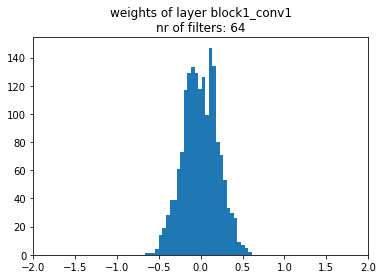

In [39]:
def plot_histogram_of_weights_for_CONV_layer(model, layer_name):
    
    if not "conv" in layer_name:        
        print("Sorry, this seems to be no CONV layer!")
        return

    lay = model.get_layer( layer_name )
    print(type(l))

    # note:
    # get_weights() returns a list with two elements:
    # list element #0: filter weights
    # list element #1: bias weights
    filter_weights = lay.get_weights()[0]
    print("filter_weights has shape", filter_weights.shape)

    # note:
    # the weights array is a 4D Numpy array with dimension:
    #   (filter_width, filter_height, nr_channels, nr_filters)
    nr_filters = filter_weights.shape[3]

    all_filter_weights = []
    for filter_nr in range(0, nr_filters):

            # get that filter weights 3D array
            single_filter_weights = filter_weights[:,:,:,filter_nr]

            #print("single_filter_weights has shape",
            #      single_filter_weights.shape)

            single_filter_weights_as_1D_array = \
                single_filter_weights.reshape(-1)

            all_filter_weights += single_filter_weights_as_1D_array.tolist()

    #print(all_filter_weights)
    plt.xlim(-2.0, +2.0)
    plt.hist(all_filter_weights, bins=30)
    plt.title("weights of layer {}\n"
              "nr of filters: {}"
              .format(layer_name, nr_filters))
    plt.show()
    
plot_histogram_of_weights_for_conv_layer(conv_base, "block1_conv1")

# Plotting weights histograms for all CONV layers

<class 'keras.layers.convolutional.Conv2D'>
filter_weights has shape (3, 3, 3, 64)


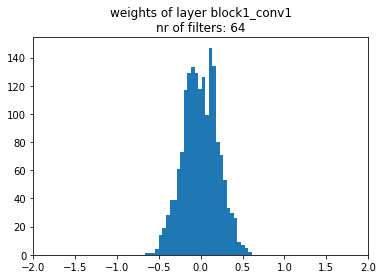

<class 'keras.layers.convolutional.Conv2D'>
filter_weights has shape (3, 3, 64, 64)


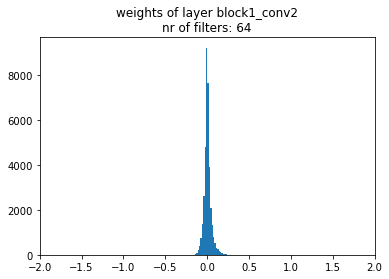

<class 'keras.layers.convolutional.Conv2D'>
filter_weights has shape (3, 3, 64, 128)


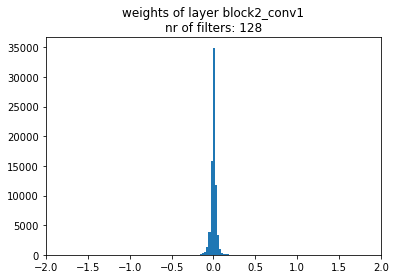

<class 'keras.layers.convolutional.Conv2D'>
filter_weights has shape (3, 3, 128, 128)


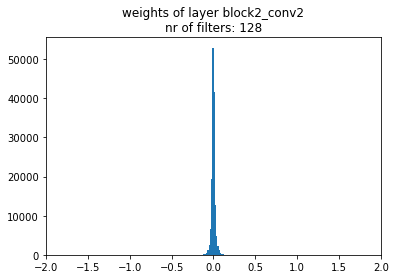

<class 'keras.layers.convolutional.Conv2D'>
filter_weights has shape (3, 3, 128, 256)


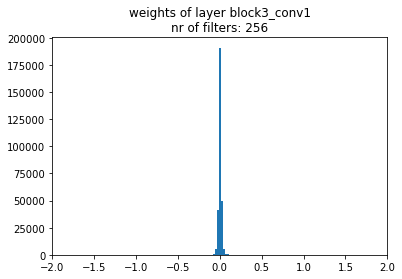

<class 'keras.layers.convolutional.Conv2D'>
filter_weights has shape (3, 3, 256, 256)


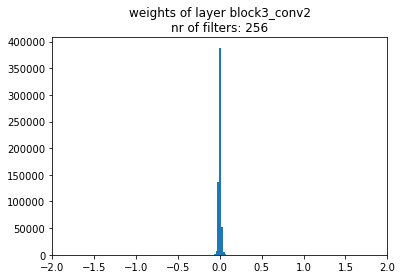

<class 'keras.layers.convolutional.Conv2D'>
filter_weights has shape (3, 3, 256, 256)


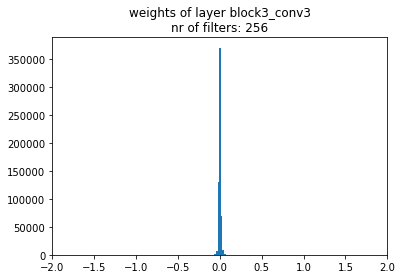

<class 'keras.layers.convolutional.Conv2D'>
filter_weights has shape (3, 3, 256, 512)


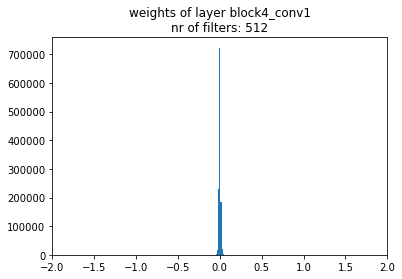

<class 'keras.layers.convolutional.Conv2D'>
filter_weights has shape (3, 3, 512, 512)


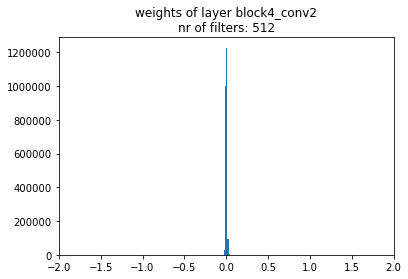

<class 'keras.layers.convolutional.Conv2D'>
filter_weights has shape (3, 3, 512, 512)


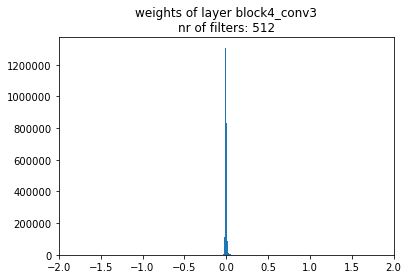

<class 'keras.layers.convolutional.Conv2D'>
filter_weights has shape (3, 3, 512, 512)


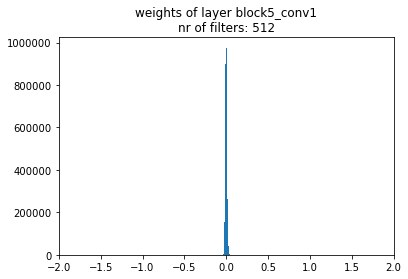

<class 'keras.layers.convolutional.Conv2D'>
filter_weights has shape (3, 3, 512, 512)


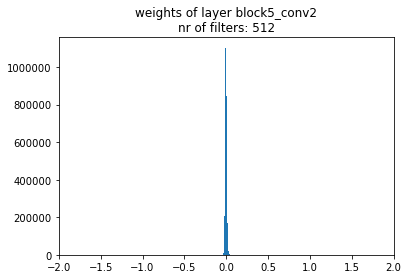

<class 'keras.layers.convolutional.Conv2D'>
filter_weights has shape (3, 3, 512, 512)


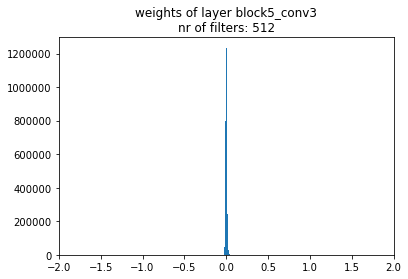

In [40]:
for layer in conv_base.layers:
    if "conv" in layer.name:
        plot_histogram_of_weights_for_CONV_layer(conv_base, layer.name)

# Plotting weights histogram for a single FC layer

<class 'keras.layers.convolutional.Conv2D'>
filter_weights has shape (25088, 4096)


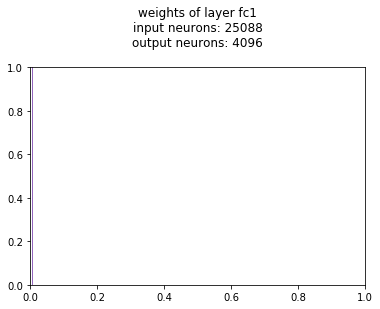

In [47]:
def plot_histogram_of_weights_for_FC_layer(model, layer_name):
    
    lay = model.get_layer( layer_name )
    print(type(l))

    # note:
    # get_weights() returns a list with two elements:
    # list element #0: filter weights
    # list element #1: bias weights
    filter_weights = lay.get_weights()[0]
    print("filter_weights has shape", filter_weights.shape)

    # note:
    # the weights array is a 2D Numpy array with dimension:
    #   (input_neurons, output_neurons)
    nr_inp_neurons = filter_weights.shape[0]
    nr_out_neurons = filter_weights.shape[1]
    
    just_some_weights_as_list = filter_weights[:100,:10].tolist()

    plt.hist(just_some_weights_as_list, bins=30)
    plt.title("weights of layer {}\n"
              "input neurons: {}\n"
              "output neurons: {}\n"
              .format(layer_name, nr_inp_neurons, nr_out_neurons))
    plt.show()
    
plot_histogram_of_weights_for_FC_layer(conv_base, "fc1")